# Practical Application 1 – Coupon Acceptance
## 1. Import Libraries & Load Data


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Make plots look nicer
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10,6)

plt.figure(figsize=(10,6))

#display all cloumns
pd.set_option('display.max_columns', None)

# Load dataset
data = pd.read_csv("../data/coupons.csv")

# Preview dataset
data.head()


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


<Figure size 1000x600 with 0 Axes>

## 2. Utility Function - As suggested by Toby Gardner.

In [5]:
def summary_stats(df) -> pd.DataFrame:

    # Create base frame
    stats = pd.DataFrame(index=df.columns)

    stats["dtype"] = df.dtypes


    stats["sample_val"] = [df[col].dropna().sample(1).iloc[0]
                            if df[col].notna().any() else np.nan
                            for col in df.columns]

    stats["vals"] = df.count()
    stats["miss_cnt"] = df.isnull().sum()
    stats["miss_pct"] = (df.isna().sum() / len(df) * 100).round(1)
    stats["unique"] = df.nunique()

    # Initiate Descriptive Stats
    for col in ["mean", "mode", "min", "max", "std", "skew", "kurtosis"]:
        stats[col] = np.nan

    # Compute stats for numeric columns
    num_cols = df.select_dtypes(include="number").columns

    for col in num_cols:
        s = df[col].dropna()
        if not s.empty:
            stats.at[col, "mean"] = s.mean()
            stats.at[col, "min"] = s.min()
            stats.at[col, "max"] = s.max()
            stats.at[col, "std"] = s.std()
            stats.at[col, "skew"] = s.skew().round(1)
            stats.at[col, "kurtosis"] = s.kurtosis().round(1)
            mode_vals = s.mode()
            stats.at[col, "mode"] = mode_vals.iloc[0] if not mode_vals.empty else np.nan

    # Rounding preferences for numeric stats (change this to suit dataset)
    round_cols = ["mean", "mode", "min", "max", "std"]
    stats[round_cols] = stats[round_cols].round(2)

    return stats

## 3. Initial Exploration

### 3.1 Summary of data and shape of the data set

In [6]:
print("Shape of dataset:", data.shape)
print("\nColumn info:")
print(data.info())

# Summary statistics
summary_stats(data)


Shape of dataset: (12684, 26)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    obje

,dtype,sample_val,vals,miss_cnt,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
destination,object,Work,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passanger,object,Alone,12684,0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,object,Sunny,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,int64,80,12684,0,0.0,3,63.30,80.0,30.0,80.0,19.15,-0.6,-1.0
time,object,10AM,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coupon,object,Bar,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expiration,object,2h,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,object,Female,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,object,31,12684,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maritalStatus,object,Married partner,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Findings

<span style="color:lightblue;">

| Column               | Missing Values | % Missing  |
| -------------------- | -------------- | ---------- |
| **car**              | 12,576         | **99.15%** |
| CoffeeHouse          | 217            | 1.71%      |
| Restaurant20To50     | 189            | 1.49%      |
| CarryAway            | 151            | 1.19%      |
| RestaurantLessThan20 | 130            | 1.02%      |
| Bar                  | 107            | 0.84%      |

The column Car seems to be missing 99.1% of data and hence this colum cannot be used in any meaningful way. 

Coupon frequency columns (CoffeeHouse, Restaurant20To50, CarryAway, RestaurantLessThan20, Bar) → Each has about 1–2% missing values, which can be:
* Dropped (rows removed), or
* Imputed (e.g., replace with "Never" or "Unknown" depending on context).

All other columns have complete data (0% missing).
</span>

## 4. Data Cleaning

Steps usually required:

* Handle missing values.

* Drop irrelevant/duplicate columns.

* Standardize categorical values.

* Encode response variable (Y).

In [45]:
# --- Data Cleaning ---

# 1. Drop 'car' column (too many missing values ~99%)
if 'car' in data.columns:
    data = data.drop(columns=['car'])

# 2. Handle missing values in coupon frequency columns
# Strategy: Replace NaN with "Never" (meaning customer never visits / didn't report visiting)
cols_to_fill = ['CoffeeHouse', 'Restaurant20To50', 'CarryAway', 'RestaurantLessThan20', 'Bar']
data[cols_to_fill] = data[cols_to_fill].fillna('never')

# 3. change misspelt column nmae
if 'passanger' in data.columns:
    data = data.rename(columns={'passanger': 'passenger'})  

summary_stats(data)



,dtype,sample_val,vals,miss_cnt,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
destination,object,No Urgent Place,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger,object,Alone,12684,0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,object,Sunny,12684,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,int64,80,12684,0,0.0,3,63.30,80.0,30.0,80.0,19.15,-0.6,-1.0
time,object,2PM,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coupon,object,Restaurant(<20),12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expiration,object,1d,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,object,Male,12684,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,object,50plus,12684,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maritalStatus,object,Single,12684,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Visualization
#### 5.1 Distribution of Coupon Acceptance

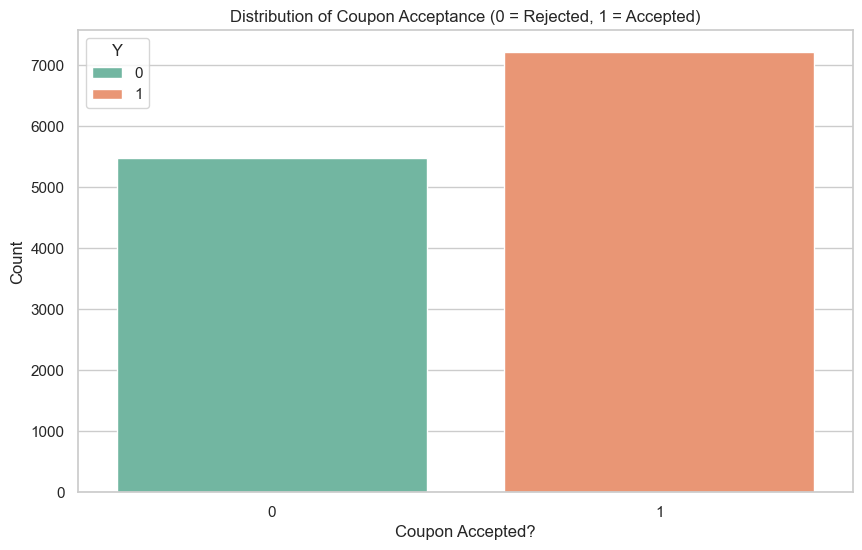

Overall acceptance rate: 56.84%


In [46]:
# Countplot for Y
sns.countplot(x="Y", data=data, hue="Y", palette="Set2")
plt.title("Distribution of Coupon Acceptance (0 = Rejected, 1 = Accepted)")
plt.xlabel("Coupon Accepted?")
plt.ylabel("Count")
plt.show()

acceptance_rate = data["Y"].mean()
print(f"Overall acceptance rate: {acceptance_rate:.2%}")

#### 5.2 Coupon Type vs. Acceptance

In [48]:
# Proportion of customers who accepted the coupon
acceptance_rate = data['Y'].mean()
print("Proportion who accepted the coupon:", round(acceptance_rate, 3))
print("Proportion who did not accept the coupon:", round(1 - acceptance_rate, 3))

# Overall acceptance rate
print("Overall acceptance rate:", round(acceptance_rate, 3))

# Acceptance rate by coupon type
acceptance_by_coupon = data.groupby('coupon')['Y'].mean().sort_values(ascending=False)

print("\nAcceptance rate by coupon type:")
print(acceptance_by_coupon)

Proportion who accepted the coupon: 0.568
Proportion who did not accept the coupon: 0.432
Overall acceptance rate: 0.568

Acceptance rate by coupon type:
coupon
Carry out & Take away    0.735478
Restaurant(<20)          0.707107
Coffee House             0.499249
Restaurant(20-50)        0.441019
Bar                      0.410015
Name: Y, dtype: float64


C:\Users\ranga\AppData\Local\Temp\ipykernel_35968\3689329009.py:7: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.boxplot(coupon_acceptance.index, coupon_acceptance.values)


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

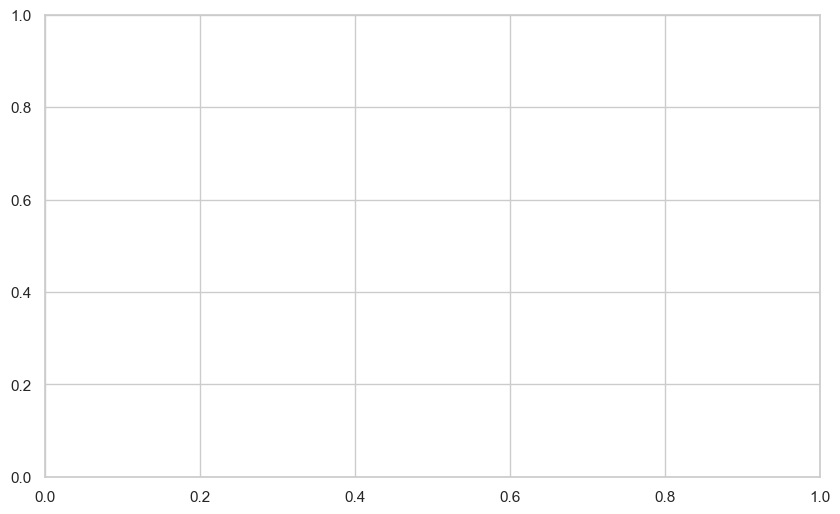

In [ ]:
# Compare acceptance across coupon types
# Calculate mean acceptance by coupon type
coupon_acceptance = data.groupby("coupon")["Y"].mean().sort_values()

# Bar chart with Matplotlib

plt.bar(coupon_acceptance.index, coupon_acceptance.values, color="skyblue")
plt.title("Coupon Acceptance Rate by Coupon Type")
plt.xlabel("Coupon Type")
plt.ylabel("Acceptance Rate")
plt.xticks(rotation=45)
plt.show()

<span style="color: red;">NOTES:</span> It is clear that coupon types "Carry out & Take away" and "Restaurant(<20)" get the most amout of tracktion as compared to the other coupon types. 

#### 5.3 Passenger Type vs. Acceptance

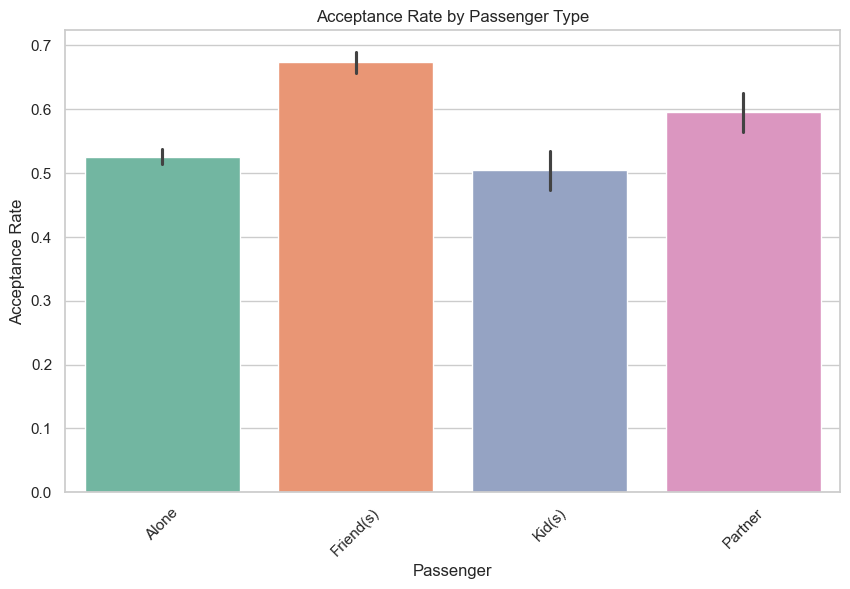

In [51]:
# Compare acceptance across who is in the car
sns.barplot(x="passenger", y="Y", data=data, estimator=np.mean, hue="passenger", palette="Set2")
plt.title("Acceptance Rate by Passenger Type")
plt.ylabel("Acceptance Rate")
plt.xlabel("Passenger")
plt.xticks(rotation=45)
plt.show()


<span style="color: red;">NOTES:</span> Coupons gets accepted more when there are friends in the car.

#### 5.4 Time of Day vs. Acceptance

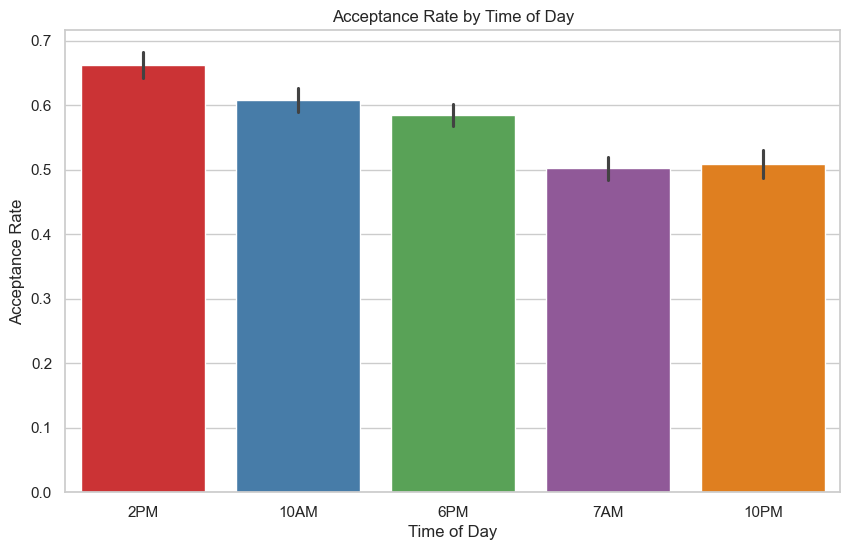

In [52]:
sns.barplot(x="time", y="Y", data=data, estimator=np.mean, hue="time", palette="Set1")
plt.title("Acceptance Rate by Time of Day")
plt.ylabel("Acceptance Rate")
plt.xlabel("Time of Day")
plt.show()

<span style="color: red;">NOTES:</span> More coupons get accpted aroudn 2PM as compared to other times. Though not significantly higher as compared to other time slots.

#### 5.5 Weather vs. Acceptance

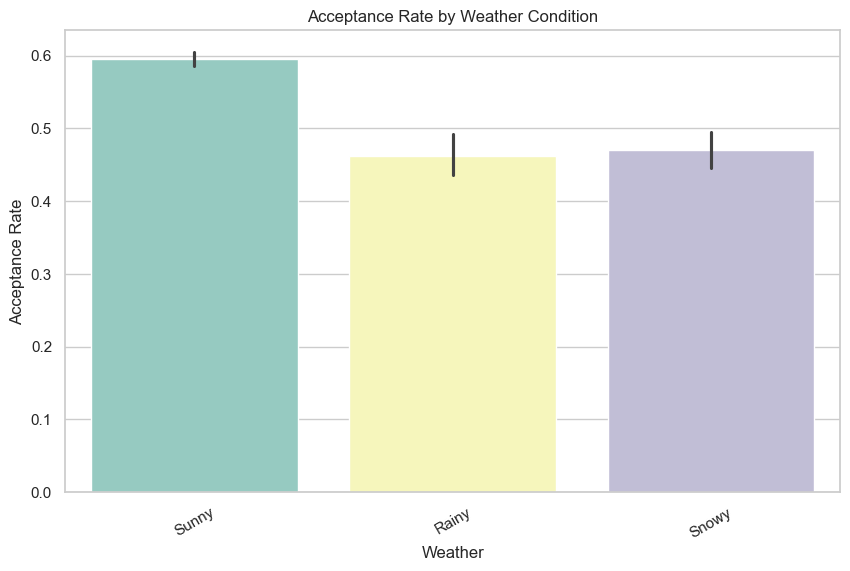

In [53]:
sns.barplot(x="weather", y="Y", data=data, estimator=np.mean, hue="weather", palette="Set3")
plt.title("Acceptance Rate by Weather Condition")
plt.ylabel("Acceptance Rate")
plt.xlabel("Weather")
plt.xticks(rotation=30)
plt.show()




<span style="color: red;">NOTES:</span> Coupons gets accpted more when it is sunny weather.

#### 5.6 Destination vs. Acceptance

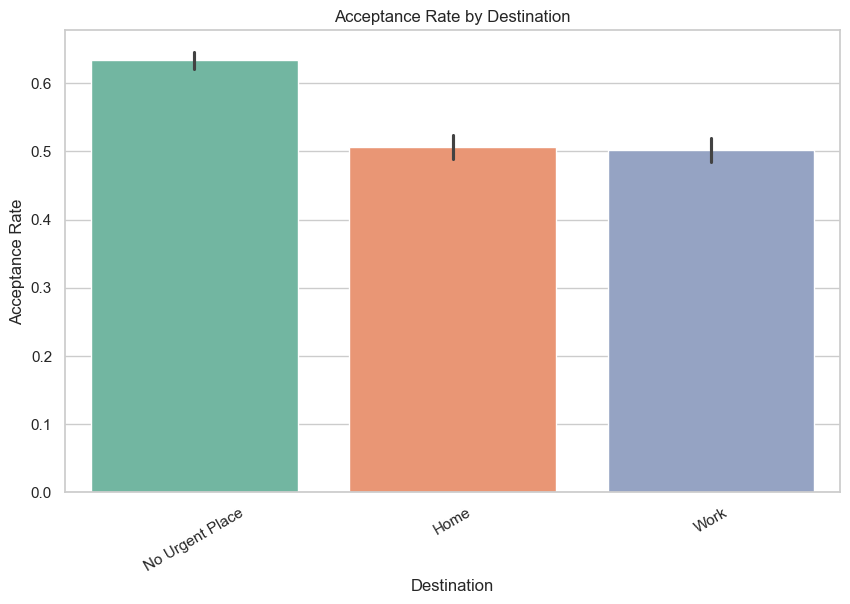

In [54]:
sns.barplot(x="destination", y="Y", data=data, estimator=np.mean, hue="destination", palette="Set2")
plt.title("Acceptance Rate by Destination")
plt.ylabel("Acceptance Rate")
plt.xlabel("Destination")
plt.xticks(rotation=30)
plt.show()

<span style="color: red;">NOTES:</span> Coupons get accepted more when drivers are going to "No Urgent Place" as compared to when they are going to "Work" or "Home"

#### 5.7 Correlation Heatmap (Numerical Columns)

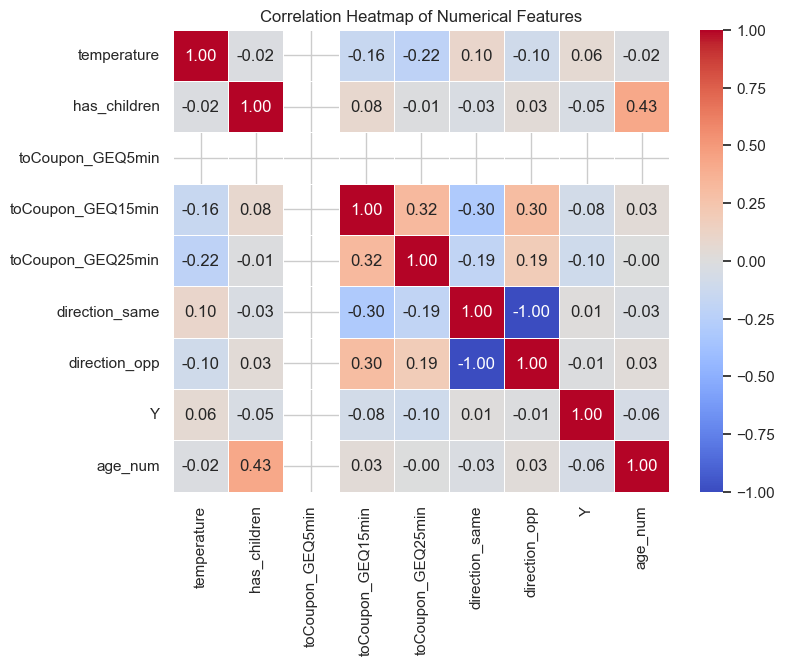

In [55]:
# Select only numerical columns
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns

# Correlation matrix
corr = data[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

<span style="color: red;">NOTES:</span> Just by using numeric columns to create a heat map does not provide a lot of meningful information.

Lets try to map the Contextual attributes and map them to numeric data and try our heat map and see we can get any meaningful insights.

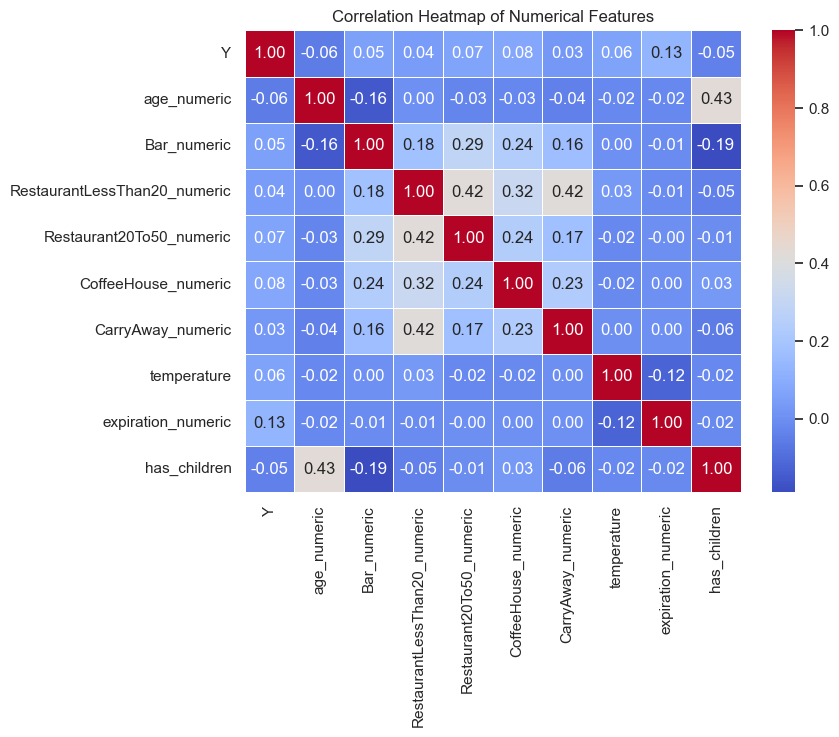

In [56]:
# Map age categories to numeric values
# I am going to call any age "50plus" as 55 for simplicity
# I am going to call any age "below21" as 20 for simplicity
age_map = {'below21': 20,'21': 21,'26': 26,'31': 31,'36': 36,'41': 41,'46': 46,'50plus': 55}
# Map bar visit frequency to numeric values
bar_map = {'never': 0,'less1': 0.5,'1~3': 2,'4~8': 6,'gt8': 10}
# Map restaurant visit frequency to numeric values
rest_map = {'never': 0,'less1': 0.5,'1~3': 2.5,'4~8': 6,'gt8': 10}
# map expiration to numeric values
expiration_map = {'1d': 1,'2h': 0.083} # 2 hours is 0.083 days

#create a copy of the data to avoid modifying original
data_mapped = data.copy()
data_mapped['age_numeric'] = data_mapped['age'].map(age_map)
data_mapped['Bar_numeric'] = data_mapped['Bar'].map(bar_map)
data_mapped['RestaurantLessThan20_numeric'] = data_mapped['RestaurantLessThan20'].map(rest_map)
data_mapped['Restaurant20To50_numeric'] = data_mapped['Restaurant20To50'].map(rest_map)
data_mapped['CoffeeHouse_numeric'] = data_mapped['CoffeeHouse'].map(rest_map)
data_mapped['CarryAway_numeric'] = data_mapped['CarryAway'].map(rest_map)
data_mapped['expiration_numeric'] = data_mapped['expiration'].map(expiration_map)

data_mapped.head()

# Select only numerical columns
#numeric_cols = data_mapped.select_dtypes(include=["int64", "float64"]).columns
numeric_columns = ['Y', 'age_numeric', 'Bar_numeric', 'RestaurantLessThan20_numeric', 'Restaurant20To50_numeric','CoffeeHouse_numeric', 'CarryAway_numeric',  'temperature',  'expiration_numeric', 'has_children']
# Correlation matrix
corr = data_mapped[numeric_columns].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


#### 5.8 Sub Plots

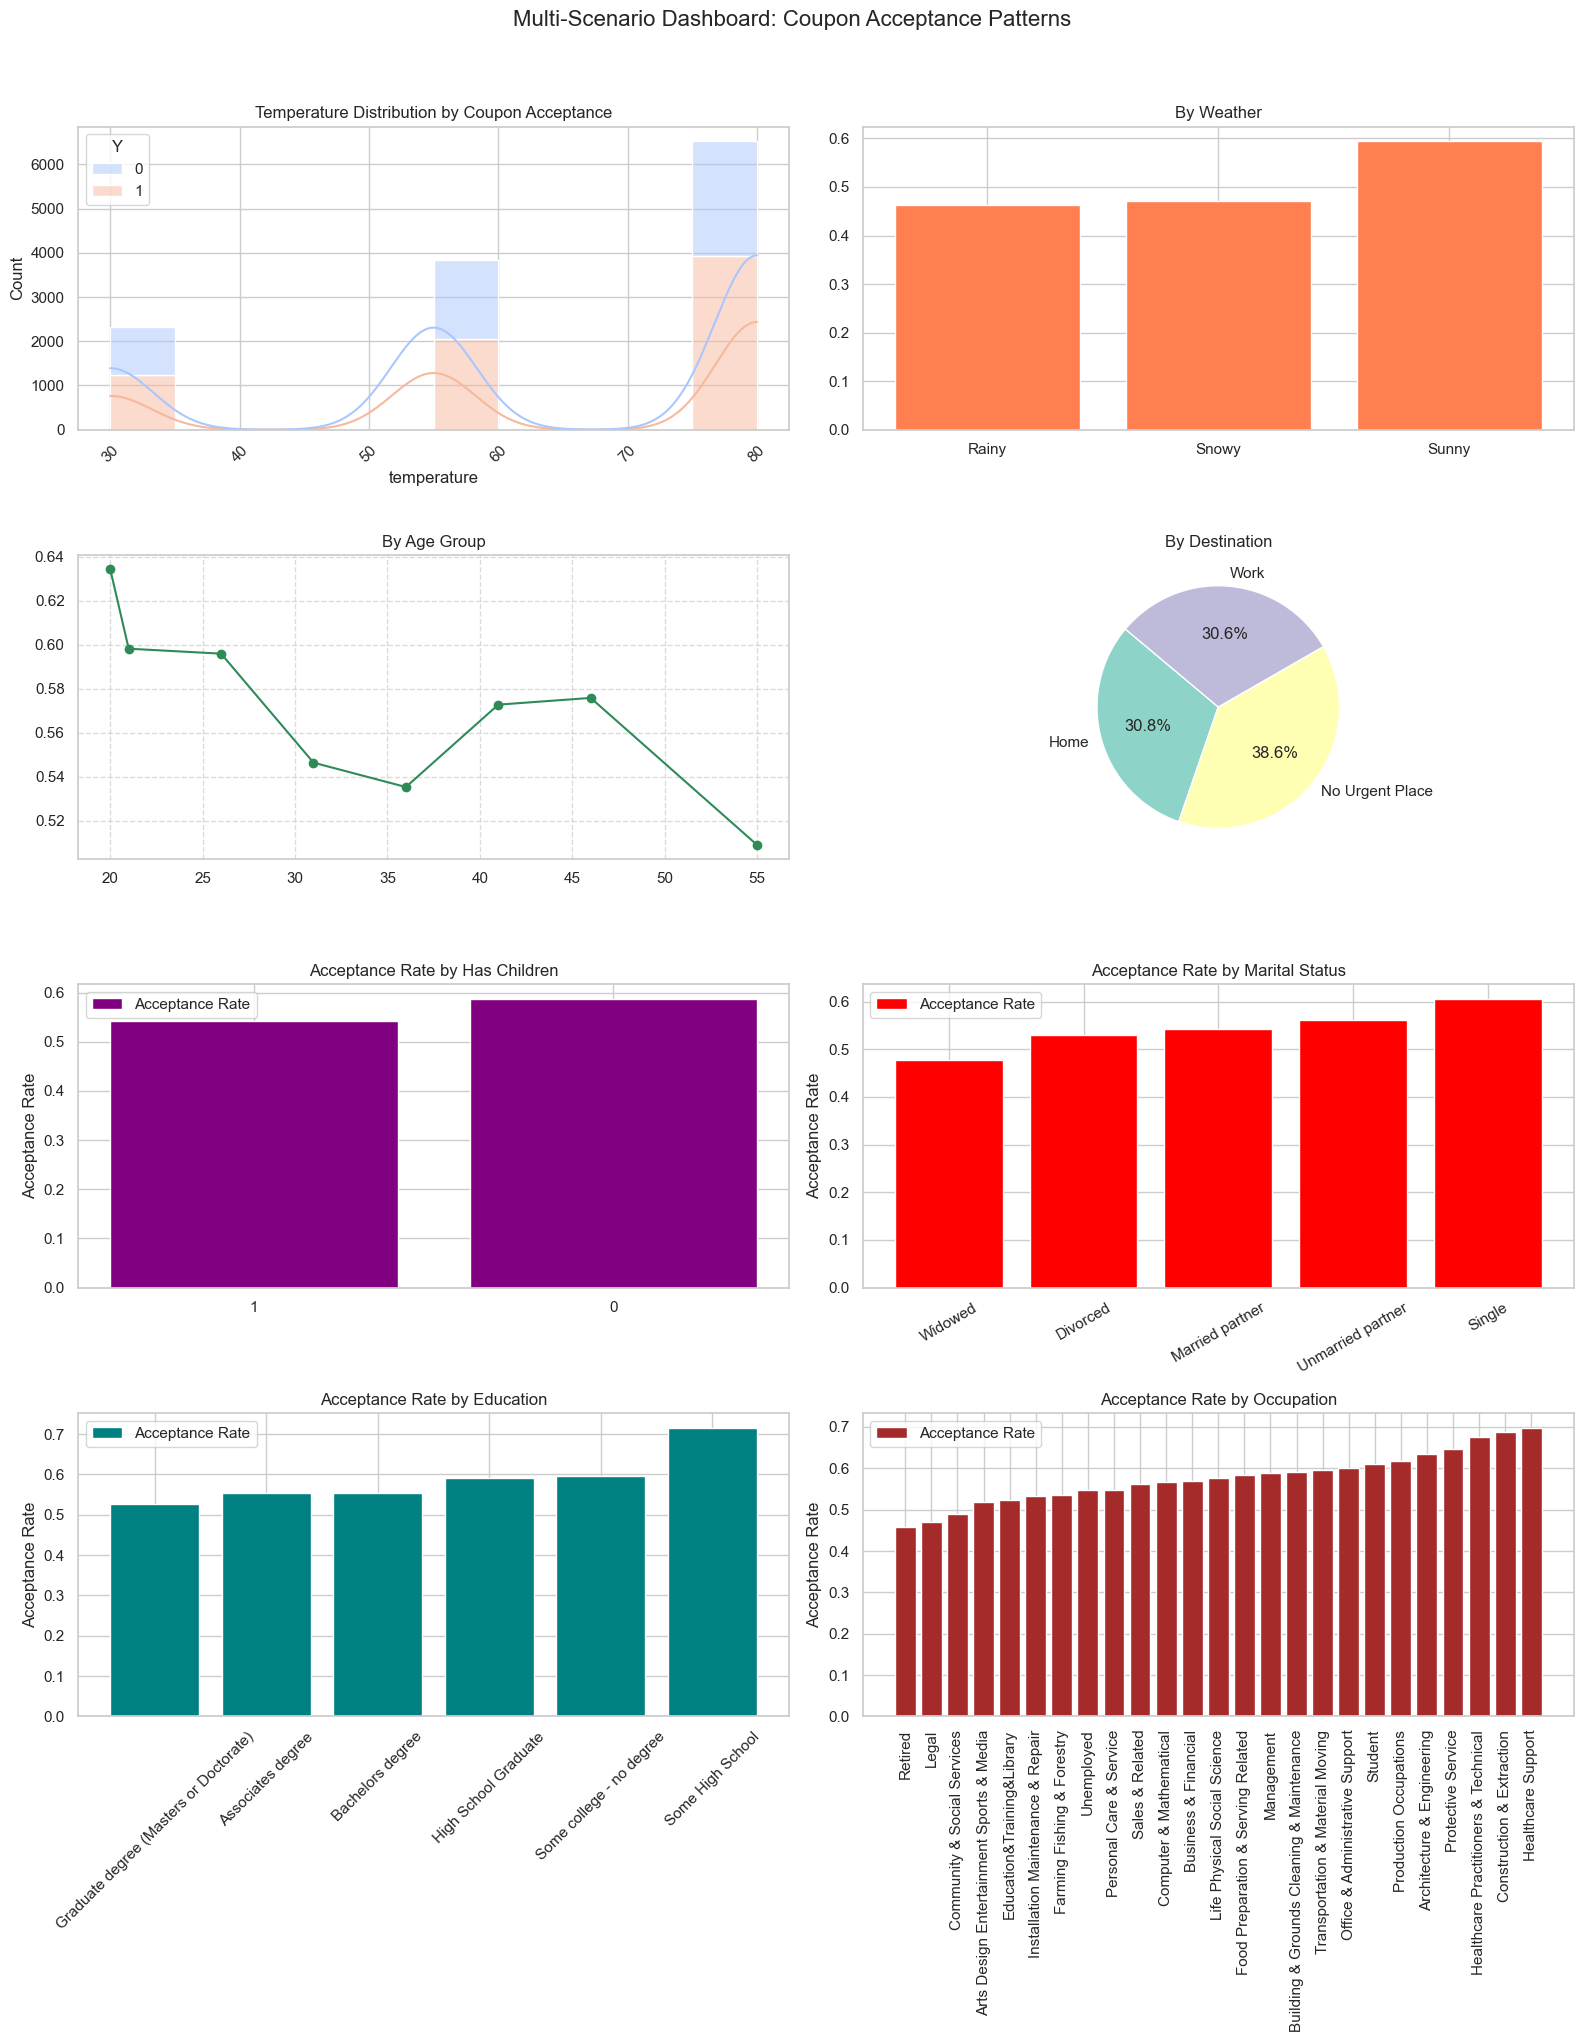

In [57]:

#trying sub plots to visualize multiple scenarios
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle("Multi-Scenario Dashboard: Coupon Acceptance Patterns", fontsize=16, y=1.02)

weather_acceptance = data.groupby("weather")["Y"].mean().sort_values()
data['age_num'] = data['age'].map(age_map)
age_acceptance = data.groupby("age_num")["Y"].mean()
destination_acceptance = data.groupby("destination")["Y"].mean()

# Temperature Distribution by Coupon Acceptance
sns.histplot(data=data, x='temperature', hue='Y', bins=10, kde=True, palette='coolwarm', multiple='stack', ax=axes[0,0])
axes[0,0].set_title('Temperature Distribution by Coupon Acceptance')
axes[0,0].tick_params(axis='x', rotation=45)

# Weather
axes[0,1].bar(weather_acceptance.index, weather_acceptance.values, color="coral")
axes[0,1].set_title("By Weather")

# Age Group
axes[1,0].plot(age_acceptance.index, age_acceptance.values, marker="o", color="seagreen")
axes[1,0].set_title("By Age Group")
axes[1,0].grid(True, linestyle="--", alpha=0.7)

# Destination
axes[1,1].pie(destination_acceptance.values, labels=destination_acceptance.index, 
              autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
axes[1,1].set_title("By Destination")

# Has Children vs Acceptance
children_acceptance = data.groupby("has_children")["Y"].mean().sort_values()
axes[2,0].bar(children_acceptance.index.astype(str), children_acceptance.values, color="purple", label="Acceptance Rate")
axes[2,0].set_title("Acceptance Rate by Has Children")
axes[2,0].set_ylabel("Acceptance Rate")
axes[2,0].legend()

# Marital Status vs Acceptance
marital_acceptance = data.groupby("maritalStatus")["Y"].mean().sort_values()
axes[2,1].bar(marital_acceptance.index, marital_acceptance.values, color="red", label="Acceptance Rate")
axes[2,1].set_title("Acceptance Rate by Marital Status")
axes[2,1].set_ylabel("Acceptance Rate")
axes[2,1].tick_params(axis="x", rotation=30)
axes[2,1].legend()

# Education vs Acceptance
edu_acceptance = data.groupby("education")["Y"].mean().sort_values()
axes[3,0].bar(edu_acceptance.index, edu_acceptance.values, color="teal", label="Acceptance Rate")
axes[3,0].set_title("Acceptance Rate by Education")
axes[3,0].set_ylabel("Acceptance Rate")
axes[3,0].tick_params(axis="x", rotation=45)
axes[3,0].legend()

# Occupation vs Acceptance
occ_acceptance = data.groupby("occupation")["Y"].mean().sort_values()
axes[3,1].bar(occ_acceptance.index, occ_acceptance.values, color="brown", label="Acceptance Rate")
axes[3,1].set_title("Acceptance Rate by Occupation")
axes[3,1].set_ylabel("Acceptance Rate")
axes[3,1].tick_params(axis="x", rotation=90)
axes[3,1].legend()

plt.tight_layout()
plt.show()

<span style="color: red;">NOTES:</span>
"Education", "Occupation", "Matital Staus" do not seem to have a huge impact on the accptance rate for coupons.
"Destination", "Age group", "Wheather", and "Temperature" seem to have a bigger impact on coupon acceptance.

#### 5.9 Families with Children vs Families without children

Acceptance rate for families with children: 0.542
Acceptance rate for families without children: 0.587


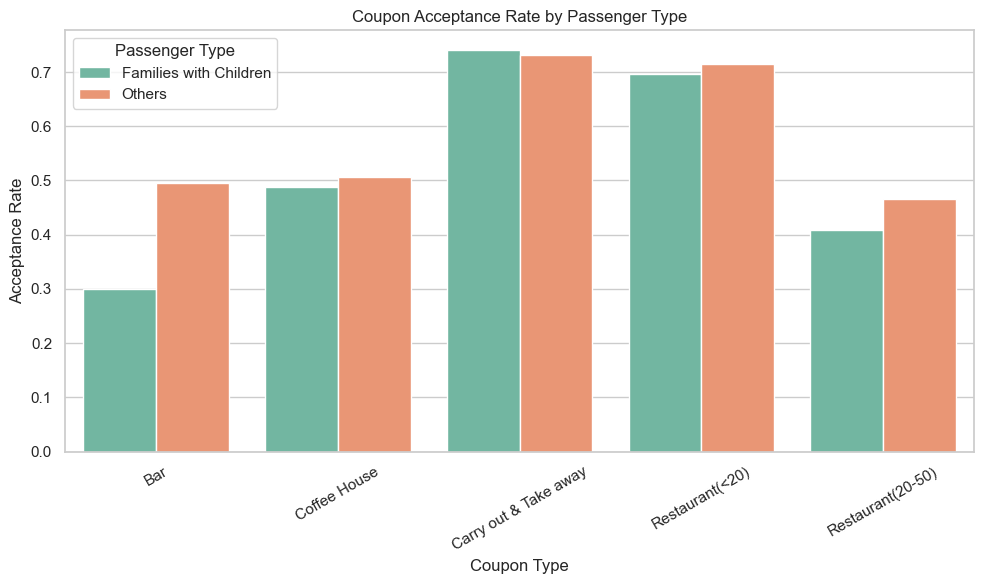

In [ ]:
families_with_children = data['has_children'] == 1
families_without_children = data['has_children'] == 0

families_with_children_acceptance = data[families_with_children]['Y'].mean()
families_without_children_acceptance = data[families_without_children]['Y'].mean()

print("Acceptance rate for families with children:", round(families_with_children_acceptance, 3))
print("Acceptance rate for families without children:", round(families_without_children_acceptance, 3))


# Define family vs. non-family groups as per has_children column
family = data[data['has_children'] == 1]
non_family = data[data['has_children'] == 0]

# List of coupon types
coupon_types = ['Bar', 'Coffee House', 'Carry out & Take away', 'Restaurant(<20)', 'Restaurant(20-50)']

# Calculate acceptance rates for each group
acceptance_family = {ctype: family[family['coupon'] == ctype]['Y'].mean() for ctype in coupon_types}
acceptance_non_family = {ctype: non_family[non_family['coupon'] == ctype]['Y'].mean() for ctype in coupon_types}

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Coupon Type': coupon_types,
    'Families with Children': [acceptance_family[ctype] for ctype in coupon_types],
    'Others': [acceptance_non_family[ctype] for ctype in coupon_types]
})

df_plot = df_plot.melt(id_vars='Coupon Type', var_name='Passenger Type', value_name='Acceptance Rate')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='Coupon Type', y='Acceptance Rate', hue='Passenger Type', palette='Set2')
plt.title('Coupon Acceptance Rate by Passenger Type')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


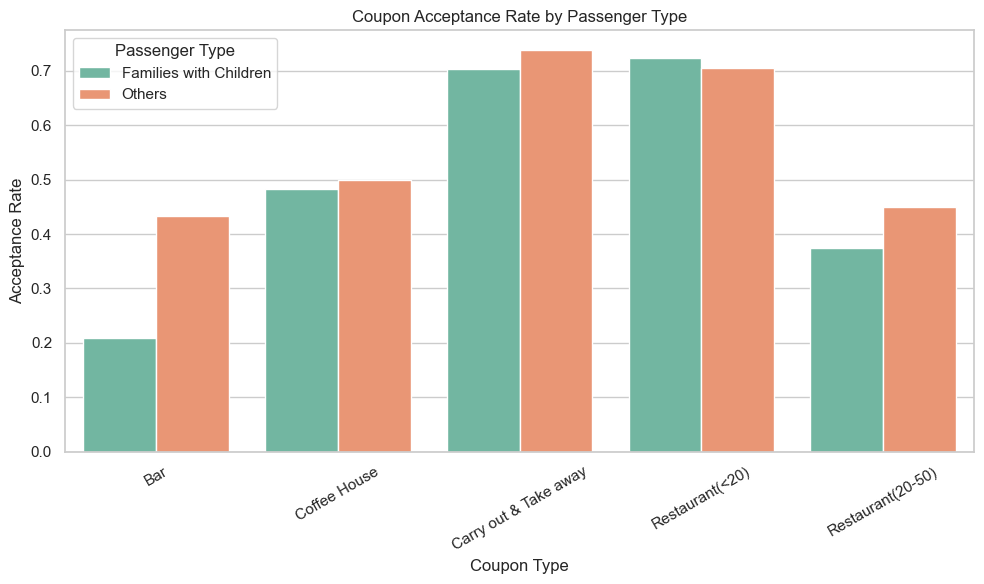

In [ ]:
# Define family vs. non-family groups as per passanger column
family = data[data['passenger'] == 'Kid(s)']
non_family = data[data['passenger'] != 'Kid(s)']

# List of coupon types
coupon_types = ['Bar', 'Coffee House', 'Carry out & Take away', 'Restaurant(<20)', 'Restaurant(20-50)']

# Calculate acceptance rates for each group
acceptance_family = {ctype: family[family['coupon'] == ctype]['Y'].mean() for ctype in coupon_types}
acceptance_non_family = {ctype: non_family[non_family['coupon'] == ctype]['Y'].mean() for ctype in coupon_types}

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Coupon Type': coupon_types,
    'Families with Children': [acceptance_family[ctype] for ctype in coupon_types],
    'Others': [acceptance_non_family[ctype] for ctype in coupon_types]
})

df_plot = df_plot.melt(id_vars='Coupon Type', var_name='Passenger Type', value_name='Acceptance Rate')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='Coupon Type', y='Acceptance Rate', hue='Passenger Type', palette='Set2')
plt.title('Coupon Acceptance Rate by Passenger Type')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### 5.10 Marrital status but specifically grouped based on if they are alone or if they are with a partner

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Bar'),
  Text(1, 0, 'Coffee House'),
  Text(2, 0, 'Carry out & Take away'),
  Text(3, 0, 'Restaurant(<20)'),
  Text(4, 0, 'Restaurant(20-50)')])

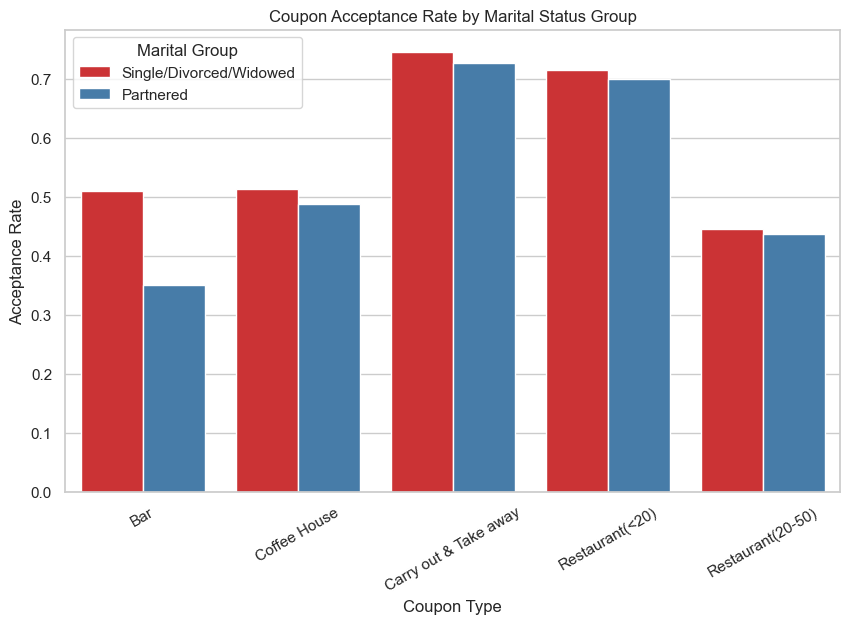

In [ ]:
# Define marital status groups 
group_a_status = ['Widowed', 'Divorced', 'Single']
group_b_status = ['Married Partner', 'Unmarried Partner']

#  Create marital group column
data['marital_group'] = data['maritalStatus'].apply(
    lambda x: 'Single/Divorced/Widowed' if x in group_a_status else 'Partnered'
)

#  List of coupon types
coupon_types = ['Bar', 'Coffee House', 'Carry out & Take away', 'Restaurant(<20)', 'Restaurant(20-50)']

# Calculate acceptance rates
acceptance_rates = []
for ctype in coupon_types:
    for group in ['Single/Divorced/Widowed', 'Partnered']:
        subset = data[(data['coupon'] == ctype) & (data['marital_group'] == group)]
        rate = subset['Y'].mean()
        acceptance_rates.append({
            'Coupon Type': ctype,
            'Marital Group': group,
            'Acceptance Rate': rate
        })

df_plot = pd.DataFrame(acceptance_rates)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='Coupon Type', y='Acceptance Rate', hue='Marital Group', palette='Set1')
plt.title('Coupon Acceptance Rate by Marital Status Group')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=30)

<span style="color: red;">NOTES:</span> People who are alone (Widowed, Divorsed or Single) tend to accpet more coupons as compared to people who have a partner.

### Findings & Recommendations

#### Key Insights from Visualizations

1. **Coupon Type Matters** 

   - Carry out & Take away and inexpensive restaurant coupons have the highest acceptance rates. [Section 5.2]

   - More expensive restaurant and bar coupons show much lower acceptance. [Section 5.2]

2. **Weather & Destination Influence Behavior**

   - Clear weather is associated with higher coupon acceptance. [Section 5.5]

   - Work-related trips have the lowest acceptance, while leisure-oriented destinations show stronger engagement. [SEction 5.6]

3. **Demographics Drive Acceptance**

   - **Age:** Younger drivers are significantly more likely to accept coupons. [Section 5.8]

   - **Has Children:** Families with children tend to accept coupons at slightly lower rates than those without. [Section 5.9]

   - **Marital Status:** Singles are more responsive to coupons than customers with a partner [Section 5.10]

   - **Education:** Acceptance rates are fairly balanced across education levels, but slightly higher among those with college or some higher education. [Section 5.8]

   - **Occupation:** Certain occupations (students, sales/service roles) show higher acceptance compared to professionals in managerial or technical roles. [Section 5.8]
---

#### Recommendations

1. **Target Younger Audiences & Students**  
   - Focus marketing campaigns on younger age groups and occupations like students - Healthcare Support, where acceptance rates are highest.  

2. **Optimize for Context**  
   - Deliver coupons during **clear weather** and **non-work trips**, especially for leisure or dining destinations.  

3. **Personalize Campaigns**  
   - **Families with children** may respond better to family-oriented promotions (e.g., restaurants, group offers).  
   - **Singles** may respond better to social or nightlife-related coupons (bars, coffee houses).  

4. **Coupon Type Strategy**  
   - Invest in **coffee house** and **inexpensive restaurant coupons**, which drive the highest engagement.  
   - Rethink or reposition **expensive restaurant coupons**, possibly by bundling with events or exclusive perks. 
